In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels


from IPython.display import HTML
%matplotlib inline

pd.options.display.precision = 15
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings("ignore")

# from bs4 import BeautifulSoup
# import requests
import time, random
import datetime
import re
import gensim
from gensim.models import CoherenceModel

## 1. Analysing data from Linked In

In [ ]:
#read in data
df = pd.read_excel('/combined and filtered - software engineering.xlsx') #, encoding='cp1252'

#print first few rows
print(df.shape)
df.head()

(828, 8)


,Unnamed: 0,job_title,company_name,company_location,work_time,post_date,Description,work_method
0,0,مطور اعمال,شركةميزة للتقييم العقاري ...,Riyadh Region,NaN,2 days ago,About the jobانضم إلى فريق ميزة للتقييم العقار...,NaN
1,1,iOS Developer,PROVEN Consult ...,"Riyadh, Saudi Arabia ...",NaN,3 weeks ago,About the jobPosition : iOS Developer (swift)Q...,NaN
2,2,Lead Online Programmer,Savvy Games Studios ...,"Riyadh, Saudi Arabia ...",NaN,4 weeks ago,About the jobSavvy Games Studios (SGS) mission...,NaN
3,3,Senior Software Engineer ...,Acquia,EMEA,NaN,1 week ago,About the jobAcquia empowers the world’s most ...,NaN
4,4,Digital Strategist,Edelman,"Riyadh, Riyadh, Saudi Arabia ...",NaN,5 days ago,"About the jobSocial Strategist, Digital - Conn...",NaN


In [ ]:
df['post_date'].apply(lambda x: len(x.split())).sum()  # Description

2484

In [ ]:
df = df.drop_duplicates(subset =['job_title', 'Description']).reset_index(drop=True)
#Replace missing values
df = df.fillna('-')

In [ ]:
len(df)

299

In [ ]:
data_df = df

### Location Mining

In [ ]:
!pip install geopandas #Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 126.3 MB/s eta 0:00:00


In [ ]:
!pip install plotly_express #Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import geopandas as gpd
import plotly_express as px

In [ ]:
map = gpd.read_file("/bin/sau_places/SAU_Places_ESRI.shp")
map['NAME'] = map['NAME'].replace('[^a-zA-Z]', '', regex=True).str.lower()

Create a copy of Data Frame to check location field

In [ ]:
df_loc = df

In [ ]:
df_loc["company_location"] = df_loc["company_location"].str.replace('\n', '')
df_loc['company_location_list'] = df_loc['company_location'].str.split(',')
df_loc['company_location_list'] = df_loc['company_location_list'].apply(lambda x: [s.strip() for s in x])
df_loc['company_location_list'] = df_loc['company_location_list'].apply(lambda x: [item for item in x if item != 'Saudi Arabia'])
df_loc['company_location_list'] = df_loc['company_location_list'].apply(lambda x: list(set(x)))
df_loc['company_location_list'] = df_loc['company_location_list'].apply(lambda x: [s.lower() for s in x])

In [ ]:
map['Job Count']=0

In [ ]:
index =0
for city in map['NAME']:
    count = df_loc['company_location_list'].apply(lambda x: x.count(city)).sum()
    map['Job Count'][index]= count
    index+=1

In [ ]:
df_filtered = map[map['Job Count'] != 0] #to only plot those not zero
# df_filtered

In [ ]:
fig = px.scatter_mapbox(df_filtered, lat='LATITUDE', lon='LONGITUDE', color="Job Count", size="Job Count",
                        center=dict(lat=map.LATITUDE.mean(),
                                    lon=map.LONGITUDE.mean()),
                  color_continuous_scale=px.colors.cyclical.IceFire, zoom=4,
                  mapbox_style="carto-positron",
                                          size_max=50)
fig.show()

### Date Post Mining

Create a copy of the Data frame

In [ ]:
df_Date = df

In [ ]:
df_Date["post_date"] = df_Date["post_date"].astype('string')
df_Date["post_date"] = df_Date["post_date"].str.replace('\n', '')
df_Date['post_date_list'] = df_Date['post_date'].str.split()
# df_Date['post_date_list'] = df_Date['post_date'].apply(lambda x: [item for item in x if item != 'ago'])
df_Date['post_date_day']=''
df_Date['post_date_list'].head()

0     [2, days, ago]
1    [3, weeks, ago]
2    [4, weeks, ago]
3     [1, week, ago]
4     [5, days, ago]
Name: post_date_list, dtype: object

In [ ]:
start_date = datetime.datetime.today() - datetime.timedelta(days=1)


In [ ]:
time = ['hour', 'day', 'week', 'month']
index=0
for job in df_Date['post_date_list']:
    for n in range(len(time)):
        pattern = r'({}|{})'.format(time[n], time[n] + 's')
        match = re.search(pattern, job[1])
        if match and time[n]=='hour':
            h = (datetime.datetime.today() - datetime.timedelta(days=3)) - datetime.timedelta(hours=int(job[0]))
            df_Date['post_date_day'][index] =str(h.strftime('%A'))
        elif match and time[n]=='day':
            d = (datetime.datetime.today() - datetime.timedelta(days=3)) - datetime.timedelta(days=int(job[0]))
            df_Date['post_date_day'][index] = str(d.strftime('%A'))
        elif match and time[n]=='week':
            w = (datetime.datetime.today() - datetime.timedelta(days=3)) - datetime.timedelta(days=(int(job[0])*7))
            df_Date['post_date_day'][index] = str(w.strftime('%A'))
        elif match and time[n]=='month':
            m = (datetime.datetime.today() - datetime.timedelta(days=3)) - datetime.timedelta(days=(int(job[0])*30))
            df_Date['post_date_day'][index] = str(m.strftime('%A'))
    index+=1
df_Date['post_date_day'].value_counts()

Tuesday      198
Sunday        33
Wednesday     21
Friday        16
Thursday      15
Monday         9
Saturday       7
Name: post_date_day, dtype: int64

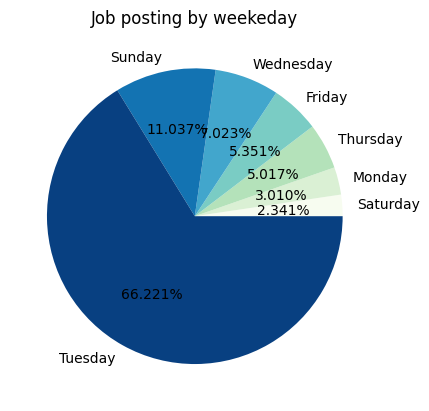

In [ ]:
df_Date['post_date_day'].value_counts().sort_values().plot(kind='pie', autopct='%.3f%%', cmap='GnBu').set(xlabel='', ylabel='', title='Job posting by weekeday')
plt.show()

### companies post

In [ ]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

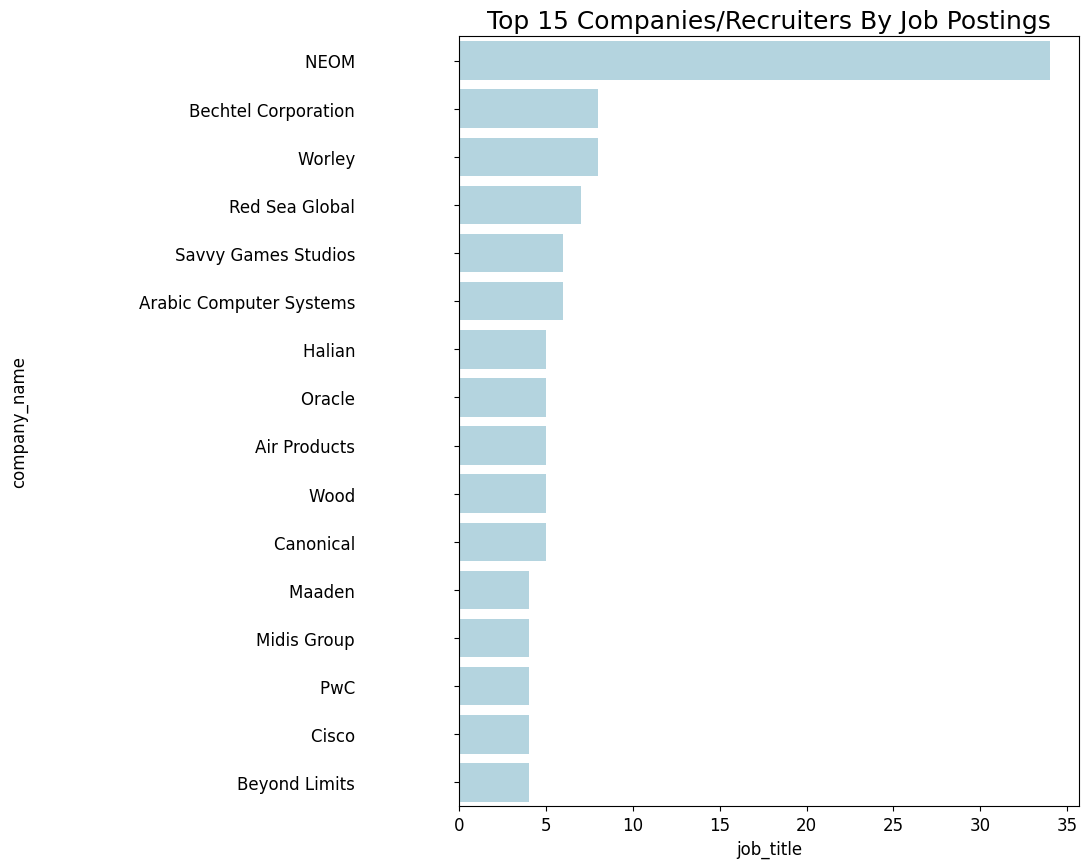

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))

#Dataset relating to recruiters
rec_df = df.groupby('company_name').count().sort_values(by='job_title', ascending=False).reset_index()[['company_name', 'job_title']].copy()

# Plot the total crashes
sns.set_color_codes("bright")
sns.barplot(x="job_title", y="company_name", data=rec_df.loc[0:15,:],
            label="Total", color="lightblue")

plt.title('Top 15 Companies/Recruiters By Job Postings', fontsize=18);

### Contract Type

Another important aspect to look into for a job search is whether the role is permanent or contract. Not all adverts on linkedIn specify this but will look into the split of permanent, contract, missing.

In [ ]:
df['work_time'].head()

0    -
1    -
2    -
3    -
4    -
Name: work_time, dtype: object

In [ ]:
df3 = df.work_time.str.split('·', expand = True)
df3.columns = ['worktime{}'.format(x+1) for x in df3.columns]
df3.head()

,worktime1,worktime2
0,-,None
1,-,None
2,-,None
3,-,None
4,-,None


In [ ]:
df['Contract'] = df3.worktime1
df['level'] = df3.worktime2

In [ ]:
print('Roles with a contract type specified:', round(df[df['Contract']!='-'].groupby('Contract')['job_title'].count().sum()/len(df),2)*100, '%')
df.groupby('Contract')['job_title'].count().reset_index()

Roles with a contract type specified: 2.0 %


,Contract,job_title
0,-,292
1,Contract,1
2,Full-time,3
3,Full-time,3


In [ ]:
#Function to return the contract type
def contract_type(x):
    if re.search('Contract', x):
        return 'Contract'
    if re.search('Temporary', x):
        return 'Contract'
    if re.search('Full-time', x):
        return 'Permanent'
    if re.search('Permanent', x):
        return 'Permanent'
    if re.search('Internship', x):
        return 'Internship'
    else:
        return x

df['Contract_Type'] = df['Contract'].apply(contract_type)
df.groupby('Contract_Type')['job_title'].count().reset_index()


,Contract_Type,job_title
0,-,292
1,Contract,1
2,Permanent,6


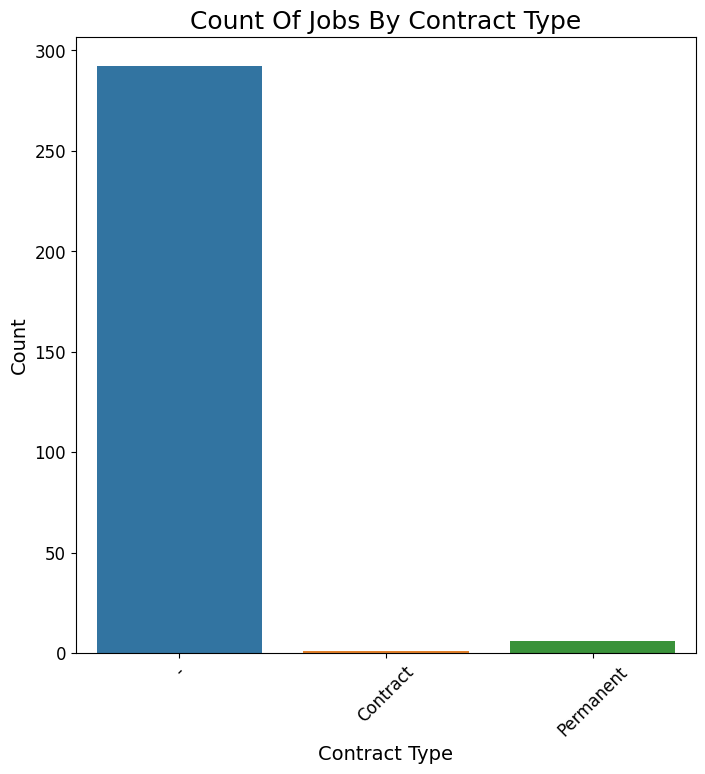

In [ ]:
contract_df = df.groupby('Contract_Type').count().reset_index()[['Contract_Type', 'job_title']]

f, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=45)

sns.barplot(x='Contract_Type', y='job_title', data=contract_df)

ax.set_title('Count Of Jobs By Contract Type', fontsize=18)
ax.set_xlabel('Contract Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

### Job Level Type

In [ ]:
print('Roles with a contract type specified:', round(df[df['level']!='-'].groupby('level')['job_title'].count().sum()/len(df),2)*100, '%')
df.groupby('level')['job_title'].count().reset_index()

Roles with a contract type specified: 1.0 %


,level,job_title
0,Director,1
1,Mid-Senior level,2


In [ ]:
# remove noisy data

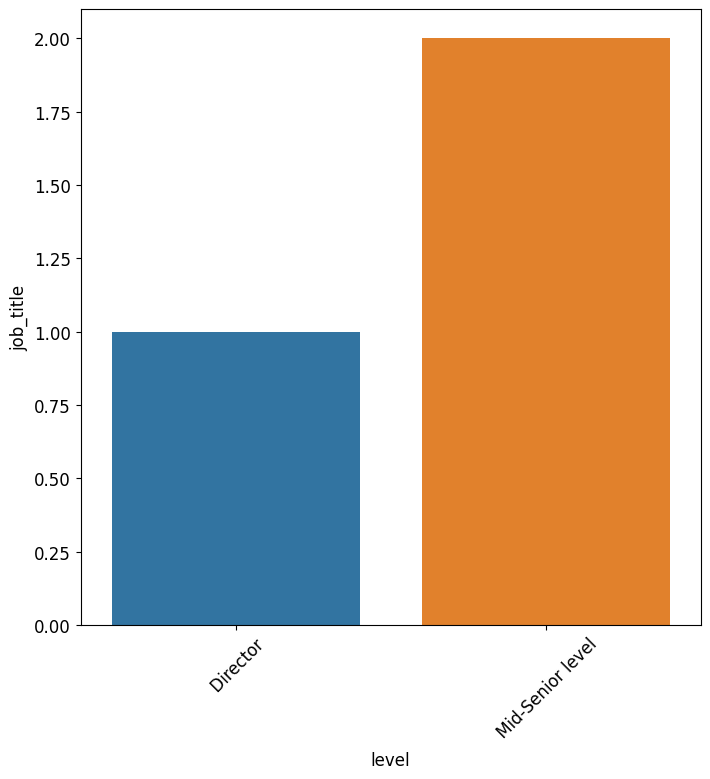

In [ ]:
contract_df = df.groupby('level').count().reset_index()[['level', 'job_title']]

f, ax = plt.subplots(figsize=(8,8))
plt.xticks(rotation=45)

sns.barplot(x='level', y='job_title', data=contract_df)

# show plot
plt.show()
ax.set_title('Count Of Jobs By level Type', fontsize=18)
ax.set_xlabel('Job Level', fontsize=14)
ax.set_ylabel('Count', fontsize=14);

### Job Description


In [ ]:
pg_lan = ["python","c++","java",".net","c#","javascript","html","bash","swift","php"]
exp_edu = ["phd","master","bachelor"]
other_skills = ["sql","oracle"]
job = df["Description"].tolist()

In [ ]:
job = [x.lower() for x in job]

In [ ]:
from collections import defaultdict

#### Programming Language

In [ ]:
pg_lan_required = defaultdict()
for item in pg_lan:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    pg_lan_required[item] = counter

pg_lan_df = pd.DataFrame(list(pg_lan_required.items()),columns = ['Programming Langauge','count'])
pg_lan_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

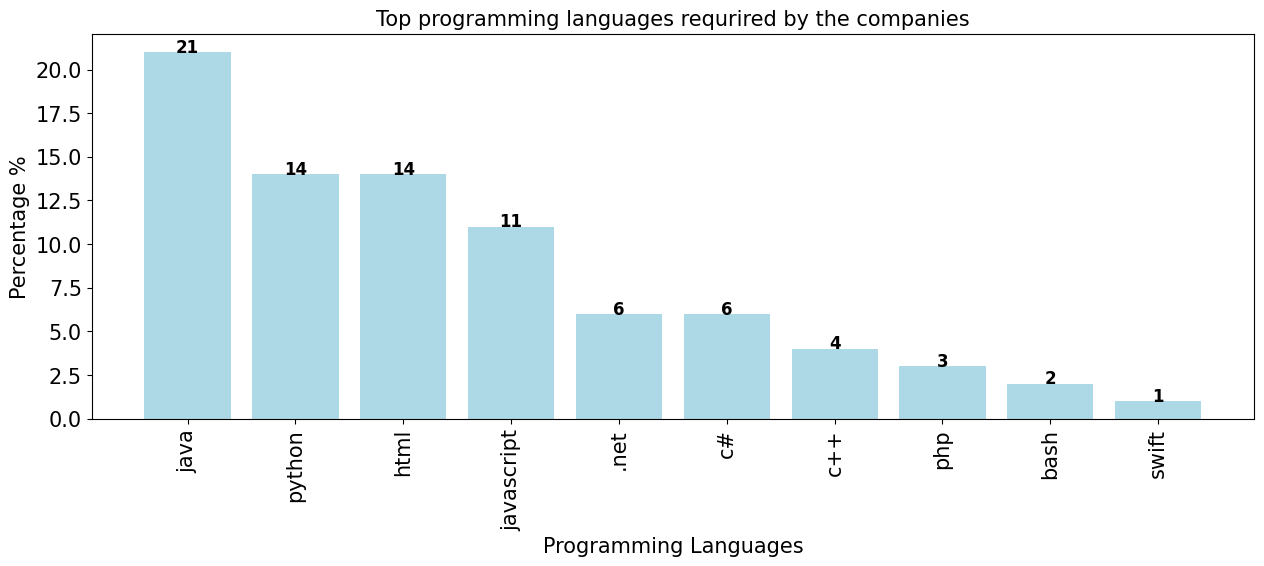

In [ ]:
plt.figure(figsize = (15,5))
x = pg_lan_df["Programming Langauge"]
y = pg_lan_df["count"]
plt.bar(x,y,color= "lightblue")
plt.title("Top programming languages requrired by the companies",fontsize=15)
plt.xlabel("Programming Languages",fontsize=15)
plt.ylabel("Percentage %",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in pg_lan_required.items():
    plt.text(k,v+0, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

#### Education level

In [ ]:
import math

In [ ]:
exp_edu_required = defaultdict()
for item in exp_edu:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    exp_edu_required[item] = counter# math.ceil((counter/len(job)  *100))

exp_edu_df = pd.DataFrame(list(exp_edu_required.items()),columns = ['Experience/Education','count'])
exp_edu_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

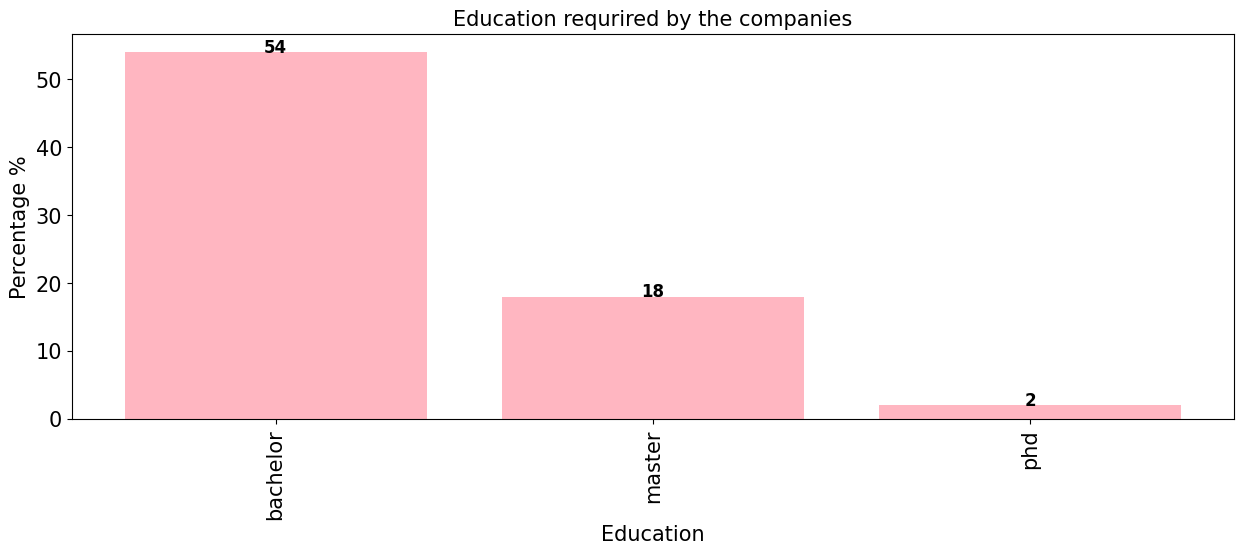

In [ ]:
plt.figure(figsize = (15,5))
x = exp_edu_df["Experience/Education"]
y = exp_edu_df["count"]
plt.bar(x,y,color= "lightpink")
plt.title("Education requrired by the companies",fontsize=15)
plt.xlabel("Education",fontsize=15)
plt.ylabel("Percentage %",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in exp_edu_required.items():
    plt.text(k,v+0, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

#### Databsase Skills

In [ ]:
counter = 0
other_skills_required = defaultdict()
for item in other_skills:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    other_skills_required[item] = counter


other_skills_df = pd.DataFrame(list(other_skills_required.items()),columns = ['Other Skills ','count'])
other_skills_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

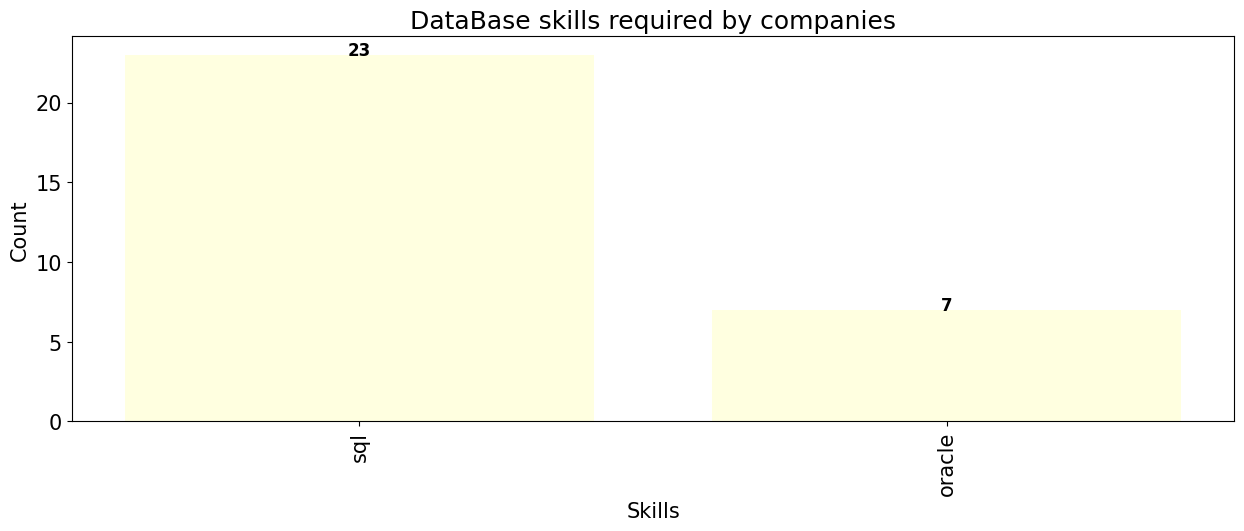

In [ ]:
plt.figure(figsize = (15,5))
plt.title("DataBase skills required by companies", fontsize=18)
plt.bar(other_skills_df["Other Skills "], other_skills_df["count"],color= "lightyellow")
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)

for k,v in other_skills_required.items():
    plt.text(k,v+0, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

##  3. Topic modelling ( Used for Data Desc)

### Removing closely worded job descriptions

Before apply topic modelling to the job descriptions in the data set, job adverts that are very similar but not identical need to be removed. I've decided the best way to remove these adverts is to transform to a vector based on their word counts and calculate their cosine similarity scores. Anything that is close to 1 without equalling 1 is very likely to be a repetition of an advert which contains a small difference.

In [ ]:
corpus = data_df['Description'] # data_df Description

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

corpus = data_df['Description']
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(corpus)

#Dataframe with cosine similarties
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))

#Dataframe for job advert and similarity with every other advert
i, j = np.indices(cos_df.shape).reshape(2, -1)
cos_values = cos_df.values.reshape(-1)
cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

#Any advert that has a cosine similarity above 0.98 and doesn't equal itself
cos_rem = cos_sim_df[(cos_sim_df['sim']>0.98)&(i!=j)]

#Method to remove duplicates but keep first instance. Trying to drop duplicates on i and j column wouldn't work as the numbers don't duplicate in those
#columns. Setting another column that combines their values ensure that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop from original dataframe
data_df = data_df[~data_df.index.isin(drop_rows)]
data_df = data_df.reset_index()
data_df.drop(columns={'index'}, inplace=True)

In [ ]:
len(data_df['Description'])

175

Using this method has removed 32 rows that were not identical but had cosine similarity scores of over 0.98.

In [ ]:
corpus = data_df['Description']

In [ ]:
import nltk #google colab
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk


wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

#Function to pre-process the text information

def normalize_document(doc):

    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = wpt.tokenize(doc)

    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]

    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]

    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]

    doc = ' '.join(lem_text)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora

Gensim requires the words (tokens) to be converted to unique ids, which can be done by creating a dictionary that maps the words to ids.
Once the dictionary has been created a bag of words corpus can be created that contains the word id and the its frequency in each document. It is effectively an equivalent of a Document-Term matrix.

In [ ]:
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora

#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=20, no_above=0.5)

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

To find the optimum number of topics, models will be built for a range of topic sizes and the one with the highest coherence score will be chosen. A previous search into optimum numbers has narrowed down the search to  be between 8 and 15.

In [ ]:
def compute_coherence_values(corpus, dictionary, texts, end, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, end, step):

        # Build LDA model
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics,
                                               random_state=123,
                                               chunksize=100,
                                               passes=500, #number of passes was investigated. At 500 the coherence score will remain relatively similar
                                               #with any further increase. As the document is quite small this number of passes makes sense.
                                               per_word_topics=True)
        model_list.append(lda_model)

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary = id2word, texts=texts, start=8, end=16, step=1)

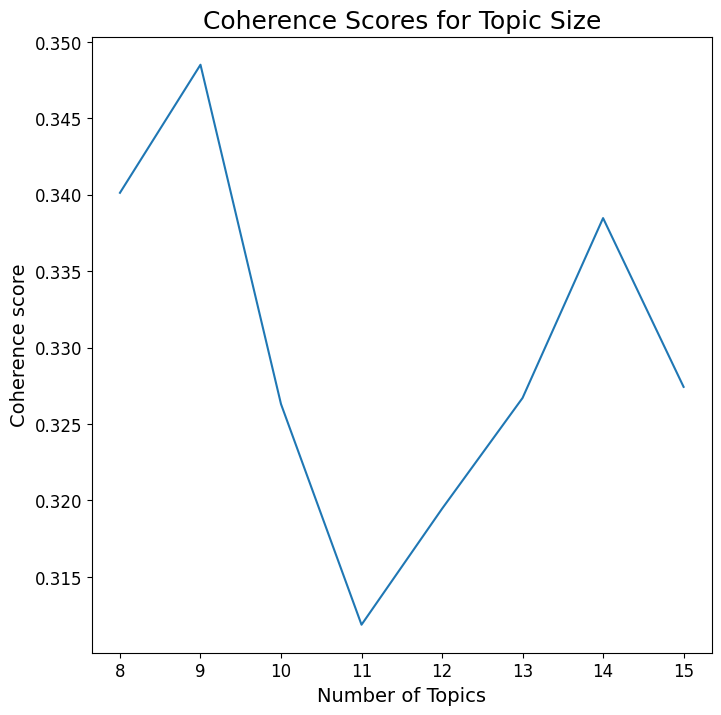

In [ ]:
# Show graph
end=16; start=8; step=1;
x = range(start, end, step)
ax = plt.subplots(figsize=(8,8))
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
plt.title('Coherence Scores for Topic Size', fontsize=18)
plt.show();

9 topics has the highest coherence score and will be chosen to build the final model

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9,
                                       random_state=123,
                                       chunksize=100,
                                       passes=500,
                                       per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Coherence Score:  0.34851272934977157


The top 10 keywords for each topic are as follows.

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

doc_lda = lda_model[corpus]


[(0,
  '0.082*"system" + 0.048*"application" + 0.036*"architecture" + '
  '0.033*"solution" + 0.033*"network" + 0.030*"information" + '
  '0.027*"technical" + 0.025*"requirement" + 0.024*"design" + '
  '0.023*"business"'),
 (1,
  '0.027*"application" + 0.024*"development" + 0.022*"work" + 0.020*"design" + '
  '0.019*"new" + 0.019*"software" + 0.017*"knowledge" + 0.016*"solution" + '
  '0.016*"science" + 0.015*"skill"'),
 (2,
  '0.043*"development" + 0.036*"support" + 0.028*"skill" + 0.027*"business" + '
  '0.025*"process" + 0.024*"system" + 0.023*"strategy" + 0.019*"related" + '
  '0.018*"management" + 0.018*"ability"'),
 (3,
  '0.052*"strategy" + 0.044*"saudi" + 0.043*"leading" + 0.038*"global" + '
  '0.038*"develop" + 0.031*"part" + 0.028*"practice" + 0.028*"well" + '
  '0.027*"key" + 0.027*"best"'),
 (4,
  '0.085*"service" + 0.079*"customer" + 0.046*"knowledge" + 0.043*"technical" '
  '+ 0.035*"support" + 0.032*"solution" + 0.030*"level" + 0.026*"work" + '
  '0.023*"ability" + 0.021

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
pprint(lda_model.print_topics()[6])

(6,
 '0.124*"project" + 0.107*"risk" + 0.081*"management" + 0.021*"process" + '
 '0.019*"knowledge" + 0.017*"stakeholder" + 0.016*"delivery" + '
 '0.016*"compliance" + 0.015*"plan" + 0.014*"planning"')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



There needs to be some human input in terms of naming the topics. For these 9 that is quite straightforward as it's evident in the majority of the topics that the keywords are connected by 1 or 2 terms. Obviously, the topics related to equal opportunities and referral scheme aren't particularly helpful, but this information is included in most adverts. A possible improvement would include words associated with these topics in the stop words.

In [ ]:
lda_dict = {0:'Project management',
            1:'Supporting clients',
            2:'Personal Requirment',
            3:'Data Base',
            4:'Analytics & Statistical Modelling',
            5:'Life cycle Phases',
            6:'Skills Projects',
            7:'Service',
            8:'none',
            9:'Release Requirment',
           '-':'-'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Top 3 topics for each document

In LDA models, each document is composed of multiple topics, although 1 or 2 will be dominant. For this work, the top 3 topics in each document will be highlighted.

In [ ]:
topics_df1 = pd.DataFrame()
topics_df2 = pd.DataFrame()
topics_df3 = pd.DataFrame()

for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if len(row) >= 3:
            if j ==0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==2:
                topics_df3 = topics_df3.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            else:
                break
        elif len(row) == 2:
            if j ==0:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
            elif j ==1:
                topics_df2 = topics_df2.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)
        elif len(row) == 1:
                topics_df1 = topics_df1.append(pd.Series([int(topic_num), prop_topic]), ignore_index=True)
                topics_df2 = topics_df2.append(pd.Series(['-', '-']), ignore_index=True)
                topics_df3 = topics_df3.append(pd.Series(['-', '-']), ignore_index=True)


topics_df1.rename(columns={0:'1st Topic', 1:'1st Topic Contribution'}, inplace=True)
topics_df2.rename(columns={0:'2nd Topic', 1:'2nd Topic Contribution'}, inplace=True)
topics_df3.rename(columns={0:'3rd Topic', 1:'3rd Topic Contribution'}, inplace=True)

topics_comb = pd.concat([topics_df1, topics_df2, topics_df3],  axis=1, sort=False)

#Join topics dataframe to original data
data_df = pd.concat([data_df, topics_comb], axis=1, sort=False)

#Combine the top 3 into one column so it's easier to analyse
data_df['Top 3 Topics'] = data_df['1st Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + data_df['2nd Topic'].apply(lambda x: lda_dict[x].join(" ,") + " ").astype(str) + \
data_df['3rd Topic'].apply(lambda x: lda_dict[x]).astype(str)

pyLDAVis is the most commonly used and best way to visualise the information contained in a topic model.

In [ ]:
pip install pyLDAvis==2.1.2 # Google Cloab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97721 sha256=25c6116f48bd17ec97661e7e6ca03f0d7522afe488c47df3394fd7f537dd982d
  Stored in directory: /root/.cache/pip/wheels/d9/93/d6/16c95da19c32f037fd75135ea152d0df37254c25cd1a8b4b6c
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                       x                  y  topics  cluster  \
topic                                                          
1      0.034698769684840 -0.006938646584851       1        1   
2     -0.045674358262467 -0.071006406546320       2        1   
5      0.033428737600312 -0.109408176877765       3        1   
6     -0.052405379125989 -0.188417257893612       4        1   
3     -0.325263361616663  0.097133250676362       5        1   
8      0.078611798802221  0.215157010892515       6        1   
7      0.090642049964281  0.148374756700308       7        1   
0      0.096023438608066 -0.057981327355984       8        1   
4      0.089938304345401 -0.026913203010652       9        1   

                     Freq  
topic                      
1      25.853984152907884  
2      18.991713496199456  
5      18.040373018332701  
6       7.985960521026792  
3       7.240377266605474  
8       7.045028266220603  
7       5.949286646105458  
0       4.702853480046600  
4       4.190423152555034  , topic_info=               Term                 Freq                Total Category  \
107            data  197.000000000000000  197.000000000000000  Default   
94          project  347.000000000000000  347.000000000000000  Default   
164      technology  151.000000000000000  151.000000000000000  Default   
187            risk  118.000000000000000  118.000000000000000  Default   
55           system  143.000000000000000  143.000000000000000  Default   
73         customer  115.000000000000000  115.000000000000000  Default   
172           cloud   78.000000000000000   78.000000000000000  Default   
96          service  106.000000000000000  106.000000000000000  Default   
147     application  120.000000000000000  120.000000000000000  Default   
0          business  185.000000000000000  185.000000000000000  Default   
77          digital   87.000000000000000   87.000000000000000  Default   
117      management  202.000000000000000  202.000000000000000  Default   
57        technical  150.000000000000000  150.000000000000000  Default   
105          client  148.000000000000000  148.000000000000000  Default   
168        security   69.000000000000000   69.000000000000000  Default   
53         solution  130.000000000000000  130.000000000000000  Default   
137        strategy  113.000000000000000  113.000000000000000  Default   
32        knowledge  144.000000000000000  144.000000000000000  Default   
139         support  157.000000000000000  157.000000000000000  Default   
9           ability   96.000000000000000   96.000000000000000  Default   
50            saudi   62.000000000000000   62.000000000000000  Default   
78      engineering  174.000000000000000  174.000000000000000  Default   
177         leading   60.000000000000000   60.000000000000000  Default   
93          product   81.000000000000000   81.000000000000000  Default   
18           design  185.000000000000000  185.000000000000000  Default   
19          develop   90.000000000000000   90.000000000000000  Default   
6       development  191.000000000000000  191.000000000000000  Default   
129         process  109.000000000000000  109.000000000000000  Default   
13     architecture   52.000000000000000   52.000000000000000  Default   
25           global   68.000000000000000   68.000000000000000  Default   
5         developer   30.580572051000615   32.545787321854959   Topic1   
99              web   32.759710359441200   36.039326904284366   Topic1   
7           science   48.427695563323077   53.355873464654998   Topic1   
11       analytical   27.455095886432211   32.569784803365906   Topic1   
159           learn   20.329223100714749   24.748779661462542   Topic1   
60             user   28.535415800386520   36.404744267193820   Topic1   
176        language   30.293342409481056   38.788805604265278   Topic1   
52         software   58.812174459043042   75.697828204020865   Topic1   
121           model   24.091632372285666   31.306392192198